In [314]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten
import cv2
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import pandas as pd
import random
import matplotlib.image as npimg
import ntpath
import os



In [315]:
datadir = 'Data'
columns = ['center','left','right','steering','throttle','reverse','speed']
data = pd.read_csv(os.path.join(datadir,'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)
data.head()

C:\Users\alexm\AppData\Local\Temp/ipykernel_23144/2854318360.py:4: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


,center,left,right,steering,throttle,reverse,speed
0,D:\Programming Projects\Self-Driving_Project\IMG\center_2021_08_05_15_07_56_776.jpg,D:\Programming Projects\Self-Driving_Project\IMG\left_2021_08_05_15_07_56_776.jpg,D:\Programming Projects\Self-Driving_Project\IMG\right_2021_08_05_15_07_56_776.jpg,0.0,0.0,0.0,0.000024
1,D:\Programming Projects\Self-Driving_Project\IMG\center_2021_08_05_15_07_56_850.jpg,D:\Programming Projects\Self-Driving_Project\IMG\left_2021_08_05_15_07_56_850.jpg,D:\Programming Projects\Self-Driving_Project\IMG\right_2021_08_05_15_07_56_850.jpg,0.0,0.0,0.0,0.000024
2,D:\Programming Projects\Self-Driving_Project\IMG\center_2021_08_05_15_07_56_925.jpg,D:\Programming Projects\Self-Driving_Project\IMG\left_2021_08_05_15_07_56_925.jpg,D:\Programming Projects\Self-Driving_Project\IMG\right_2021_08_05_15_07_56_925.jpg,0.0,0.0,0.0,0.000024
3,D:\Programming Projects\Self-Driving_Project\IMG\center_2021_08_05_15_07_57_000.jpg,D:\Programming Projects\Self-Driving_Project\IMG\left_2021_08_05_15_07_57_000.jpg,D:\Programming Projects\Self-Driving_Project\IMG\right_2021_08_05_15_07_57_000.jpg,0.0,0.0,0.0,0.000024
4,D:\Programming Projects\Self-Driving_Project\IMG\center_2021_08_05_15_07_57_075.jpg,D:\Programming Projects\Self-Driving_Project\IMG\left_2021_08_05_15_07_57_075.jpg,D:\Programming Projects\Self-Driving_Project\IMG\right_2021_08_05_15_07_57_075.jpg,0.0,0.0,0.0,0.000024


In [316]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2021_08_05_15_07_56_776.jpg,left_2021_08_05_15_07_56_776.jpg,right_2021_08_05_15_07_56_776.jpg,0.0,0.0,0.0,0.000024
1,center_2021_08_05_15_07_56_850.jpg,left_2021_08_05_15_07_56_850.jpg,right_2021_08_05_15_07_56_850.jpg,0.0,0.0,0.0,0.000024
2,center_2021_08_05_15_07_56_925.jpg,left_2021_08_05_15_07_56_925.jpg,right_2021_08_05_15_07_56_925.jpg,0.0,0.0,0.0,0.000024
3,center_2021_08_05_15_07_57_000.jpg,left_2021_08_05_15_07_57_000.jpg,right_2021_08_05_15_07_57_000.jpg,0.0,0.0,0.0,0.000024
4,center_2021_08_05_15_07_57_075.jpg,left_2021_08_05_15_07_57_075.jpg,right_2021_08_05_15_07_57_075.jpg,0.0,0.0,0.0,0.000024


[-0.96 -0.88 -0.8  -0.72 -0.64 -0.56 -0.48 -0.4  -0.32 -0.24 -0.16 -0.08
  0.    0.08  0.16  0.24  0.32  0.4   0.48  0.56  0.64  0.72  0.8   0.88
  0.96]


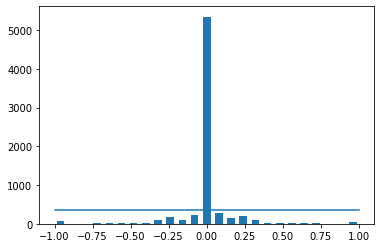

In [317]:
num_bins = 25
samples_per_bin = 360
hist, bins = np.histogram(data['steering'], num_bins)
center = (bins[:-1]+ bins[1:])*0.5
print(center)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])), (samples_per_bin,samples_per_bin))
plt.show()

total data 7000
removed 4987
remaining data 2013


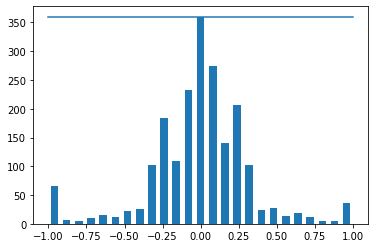

In [318]:
print('total data', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data['steering'])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)


print('removed', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining data', len(data))

hist, _ = np.histogram(data['steering'], (num_bins))
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']),np.max(data['steering'])), (samples_per_bin,samples_per_bin))
plt.show()

In [319]:
print(data.iloc[1])
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steering

image_paths, steerings = load_img_steering(datadir + '/IMG', data)


center      center_2021_08_05_15_07_58_597.jpg
left        left_2021_08_05_15_07_58_597.jpg  
right       right_2021_08_05_15_07_58_597.jpg 
steering   -0.1                               
throttle    1.0                               
reverse     0.0                               
speed       10.97524                          
Name: 24, dtype: object


In [320]:
X_train, x_valid, y_train, y_valid =  train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('training samples {}\nValid Samples: {}'.format(len(X_train),len(x_valid)))

training samples 1610
Valid Samples: 403


Text(0.5, 1.0, 'Validation set')

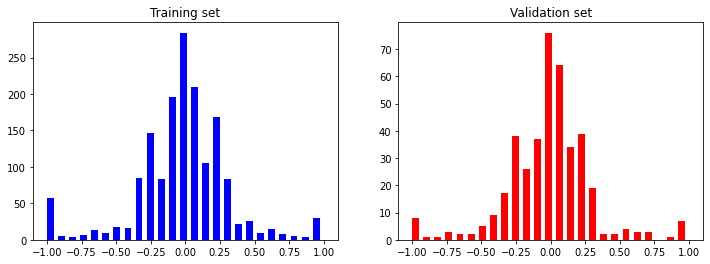

In [321]:
fig, axes = plt.subplots(1,2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [322]:
def image_preprocess(img):
    img = npimg.imread(img)
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,(3,3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

Text(0.5, 1.0, 'Preprocessed Image')

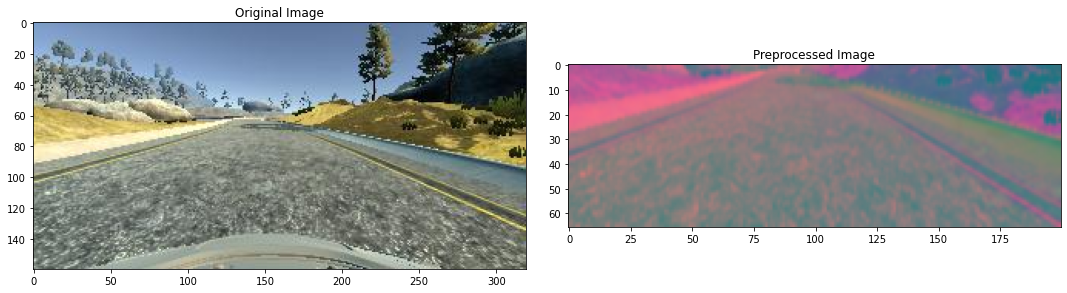

In [323]:
image = image_paths[200]
original_image = npimg.imread(image)

preprocessed_image = image_preprocess(image)

fig, axes = plt.subplots(1,2, figsize=(15,10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title('Original Image')
axes[1].imshow(preprocessed_image)
axes[1].set_title('Preprocessed Image')
# plt.show()


In [ ]:
X_train = np.array(list(map(image_preprocess, X_train)))
X_valid = np.array(list(map(image_preprocess, x_valid)))

In [ ]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
print(X_train.shape)